In [1]:
import yaml
with open('config.yaml', 'r') as config:
    cfg = yaml.safe_load(config)

In [2]:
import pandas as pd
import numpy as np
from numpy.typing import NDArray
from matplotlib import pyplot as plt
import seaborn as sns
import json

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [4]:
import category_encoders as ce
from category_encoders import wrapper
from scipy import stats

In [11]:
df = pd.read_csv(cfg["dataset"])

In [12]:
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [14]:
df.columns, df.shape[0]

(Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
        'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
        'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
        'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
        'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
        'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
        'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
        'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
        'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
        'Astronomical_Twilight'],
       dtype='object'),
 800000)

In [63]:
df.isna().sum().sort_values(ascending=False)

End_Lat                  800000
End_Lng                  800000
Precipitation(in)        380095
Wind_Chill(F)            368432
Wind_Speed(mph)           80220
Visibility(mi)            15136
Weather_Condition         14507
Humidity(%)               13224
Temperature(F)            12206
Wind_Direction            10797
Pressure(in)               9865
Weather_Timestamp          7902
Street                     1374
Nautical_Twilight          1349
Civil_Twilight             1349
Sunrise_Sunset             1349
Astronomical_Twilight      1349
Airport_Code               1151
Timezone                    360
Zipcode                     110
City                         24
Description                   1
No_Exit                       0
Severity                      0
Start_Time                    0
End_Time                      0
Turning_Loop                  0
Traffic_Signal                0
Traffic_Calming               0
Stop                          0
Station                       0
Roundabo

(nan, nan)

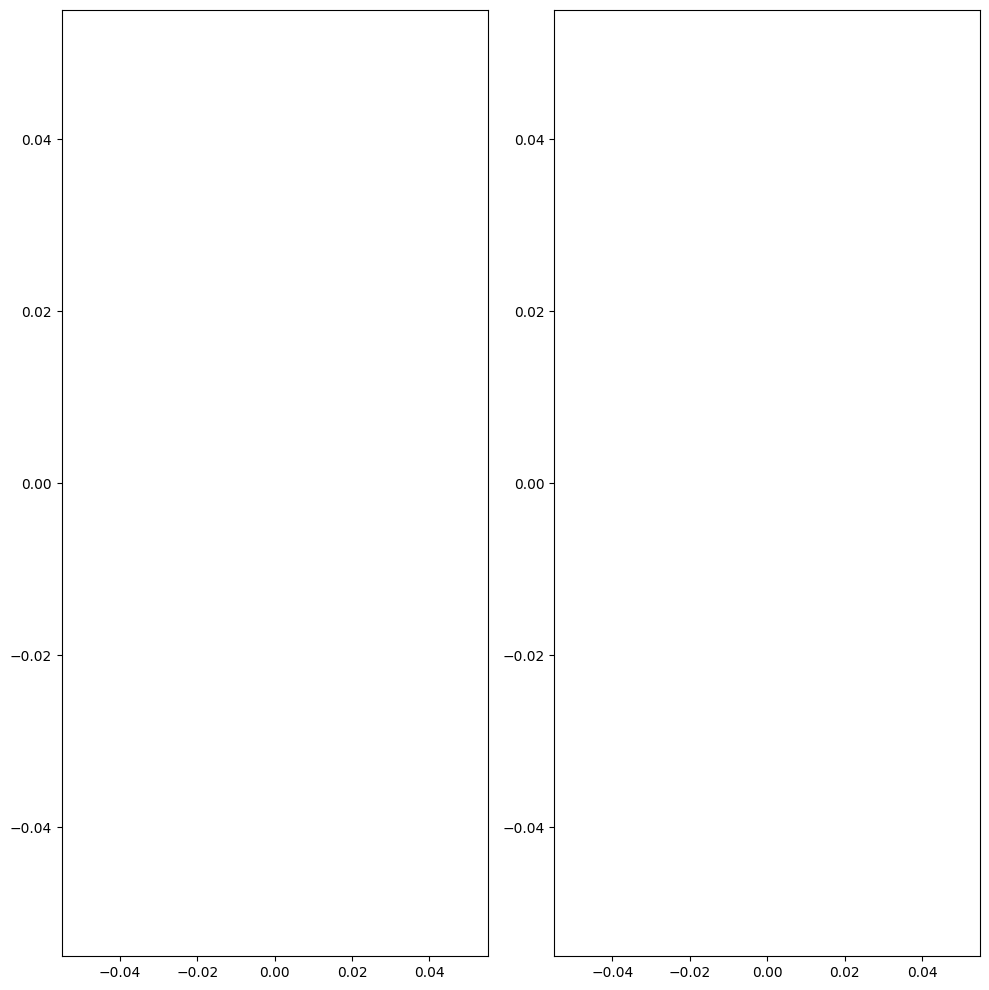

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
df_cor = df[['Start_Lat', 'End_Lat', 'Start_Lng', 'End_Lng']]
df_cor.dropna()
axes[0].plot(df_cor['Start_Lat'], df_cor['End_Lat'], 'ro', linestyle="None")
axes[1].plot(df_cor['Start_Lng'], df_cor['End_Lng'], 'bo', linestyle="None")
fig.tight_layout()

df['Start_Lat'].corr(df['End_Lat']), df['Start_Lng'].corr(df['End_Lng'])

In [17]:
def add_column_mean_coordinate(start: pd.Series, end: pd.Series) -> pd.Series:
    fill_end = end.fillna(start)
    new_series = (start + fill_end) / 2
    return new_series
 
df['Lat'] = add_column_mean_coordinate(df['Start_Lat'], df['End_Lat'])
df['Lng'] = add_column_mean_coordinate(df['Start_Lng'], df['End_Lng'])

In [64]:
nan_df = (df.isnull().mean() * 100).reset_index()
nan_df.columns = ["column_name", "percentage"]
nan_df.sort_values("percentage", ascending=False, inplace=True)
nan_df.head(10)

,column_name,percentage
7,End_Lat,100.000000
8,End_Lng,100.000000
27,Precipitation(in),47.511875
21,Wind_Chill(F),46.054000
26,Wind_Speed(mph),10.027500
24,Visibility(mi),1.892000
28,Weather_Condition,1.813375
22,Humidity(%),1.653000
20,Temperature(F),1.525750
25,Wind_Direction,1.349625


In [19]:
df.drop(columns=['ID', 'Source', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng'], inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800000 entries, 760648 to 985772
Data columns (total 42 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Severity               800000 non-null  int64  
 1   Start_Time             800000 non-null  object 
 2   End_Time               800000 non-null  object 
 3   Distance(mi)           800000 non-null  float64
 4   Description            799999 non-null  object 
 5   Street                 798626 non-null  object 
 6   City                   799976 non-null  object 
 7   County                 800000 non-null  object 
 8   State                  800000 non-null  object 
 9   Zipcode                799890 non-null  object 
 10  Country                800000 non-null  object 
 11  Timezone               799640 non-null  object 
 12  Airport_Code           798849 non-null  object 
 13  Weather_Timestamp      792098 non-null  object 
 14  Temperature(F)         787794 non-nu

In [21]:
num_df = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
bool_df = df.select_dtypes(exclude=['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'object'])
cat_df = df.select_dtypes(include=['object'])
len(num_df.columns), len(bool_df.columns), len(cat_df.columns)

(11, 13, 18)

In [22]:
num_df.columns, bool_df.columns, cat_df.columns

(Index(['Severity', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)',
        'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
        'Precipitation(in)', 'Lat', 'Lng'],
       dtype='object'),
 Index(['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
        'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
        'Traffic_Signal', 'Turning_Loop'],
       dtype='object'),
 Index(['Start_Time', 'End_Time', 'Description', 'Street', 'City', 'County',
        'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code',
        'Weather_Timestamp', 'Wind_Direction', 'Weather_Condition',
        'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
        'Astronomical_Twilight'],
       dtype='object'))

Заметим, что булевые признаки, кроме Amenity показывают на то, где произошло ДТП:
"Отбойник", "Перекресток", "Уступка", "Развязка", "Запретный выезд", "Железная дорога", "Кольцевая развязка", "Станция", "Остановка", "Регулировка движения", "Дорожный сигнал", "Поворотная петля"


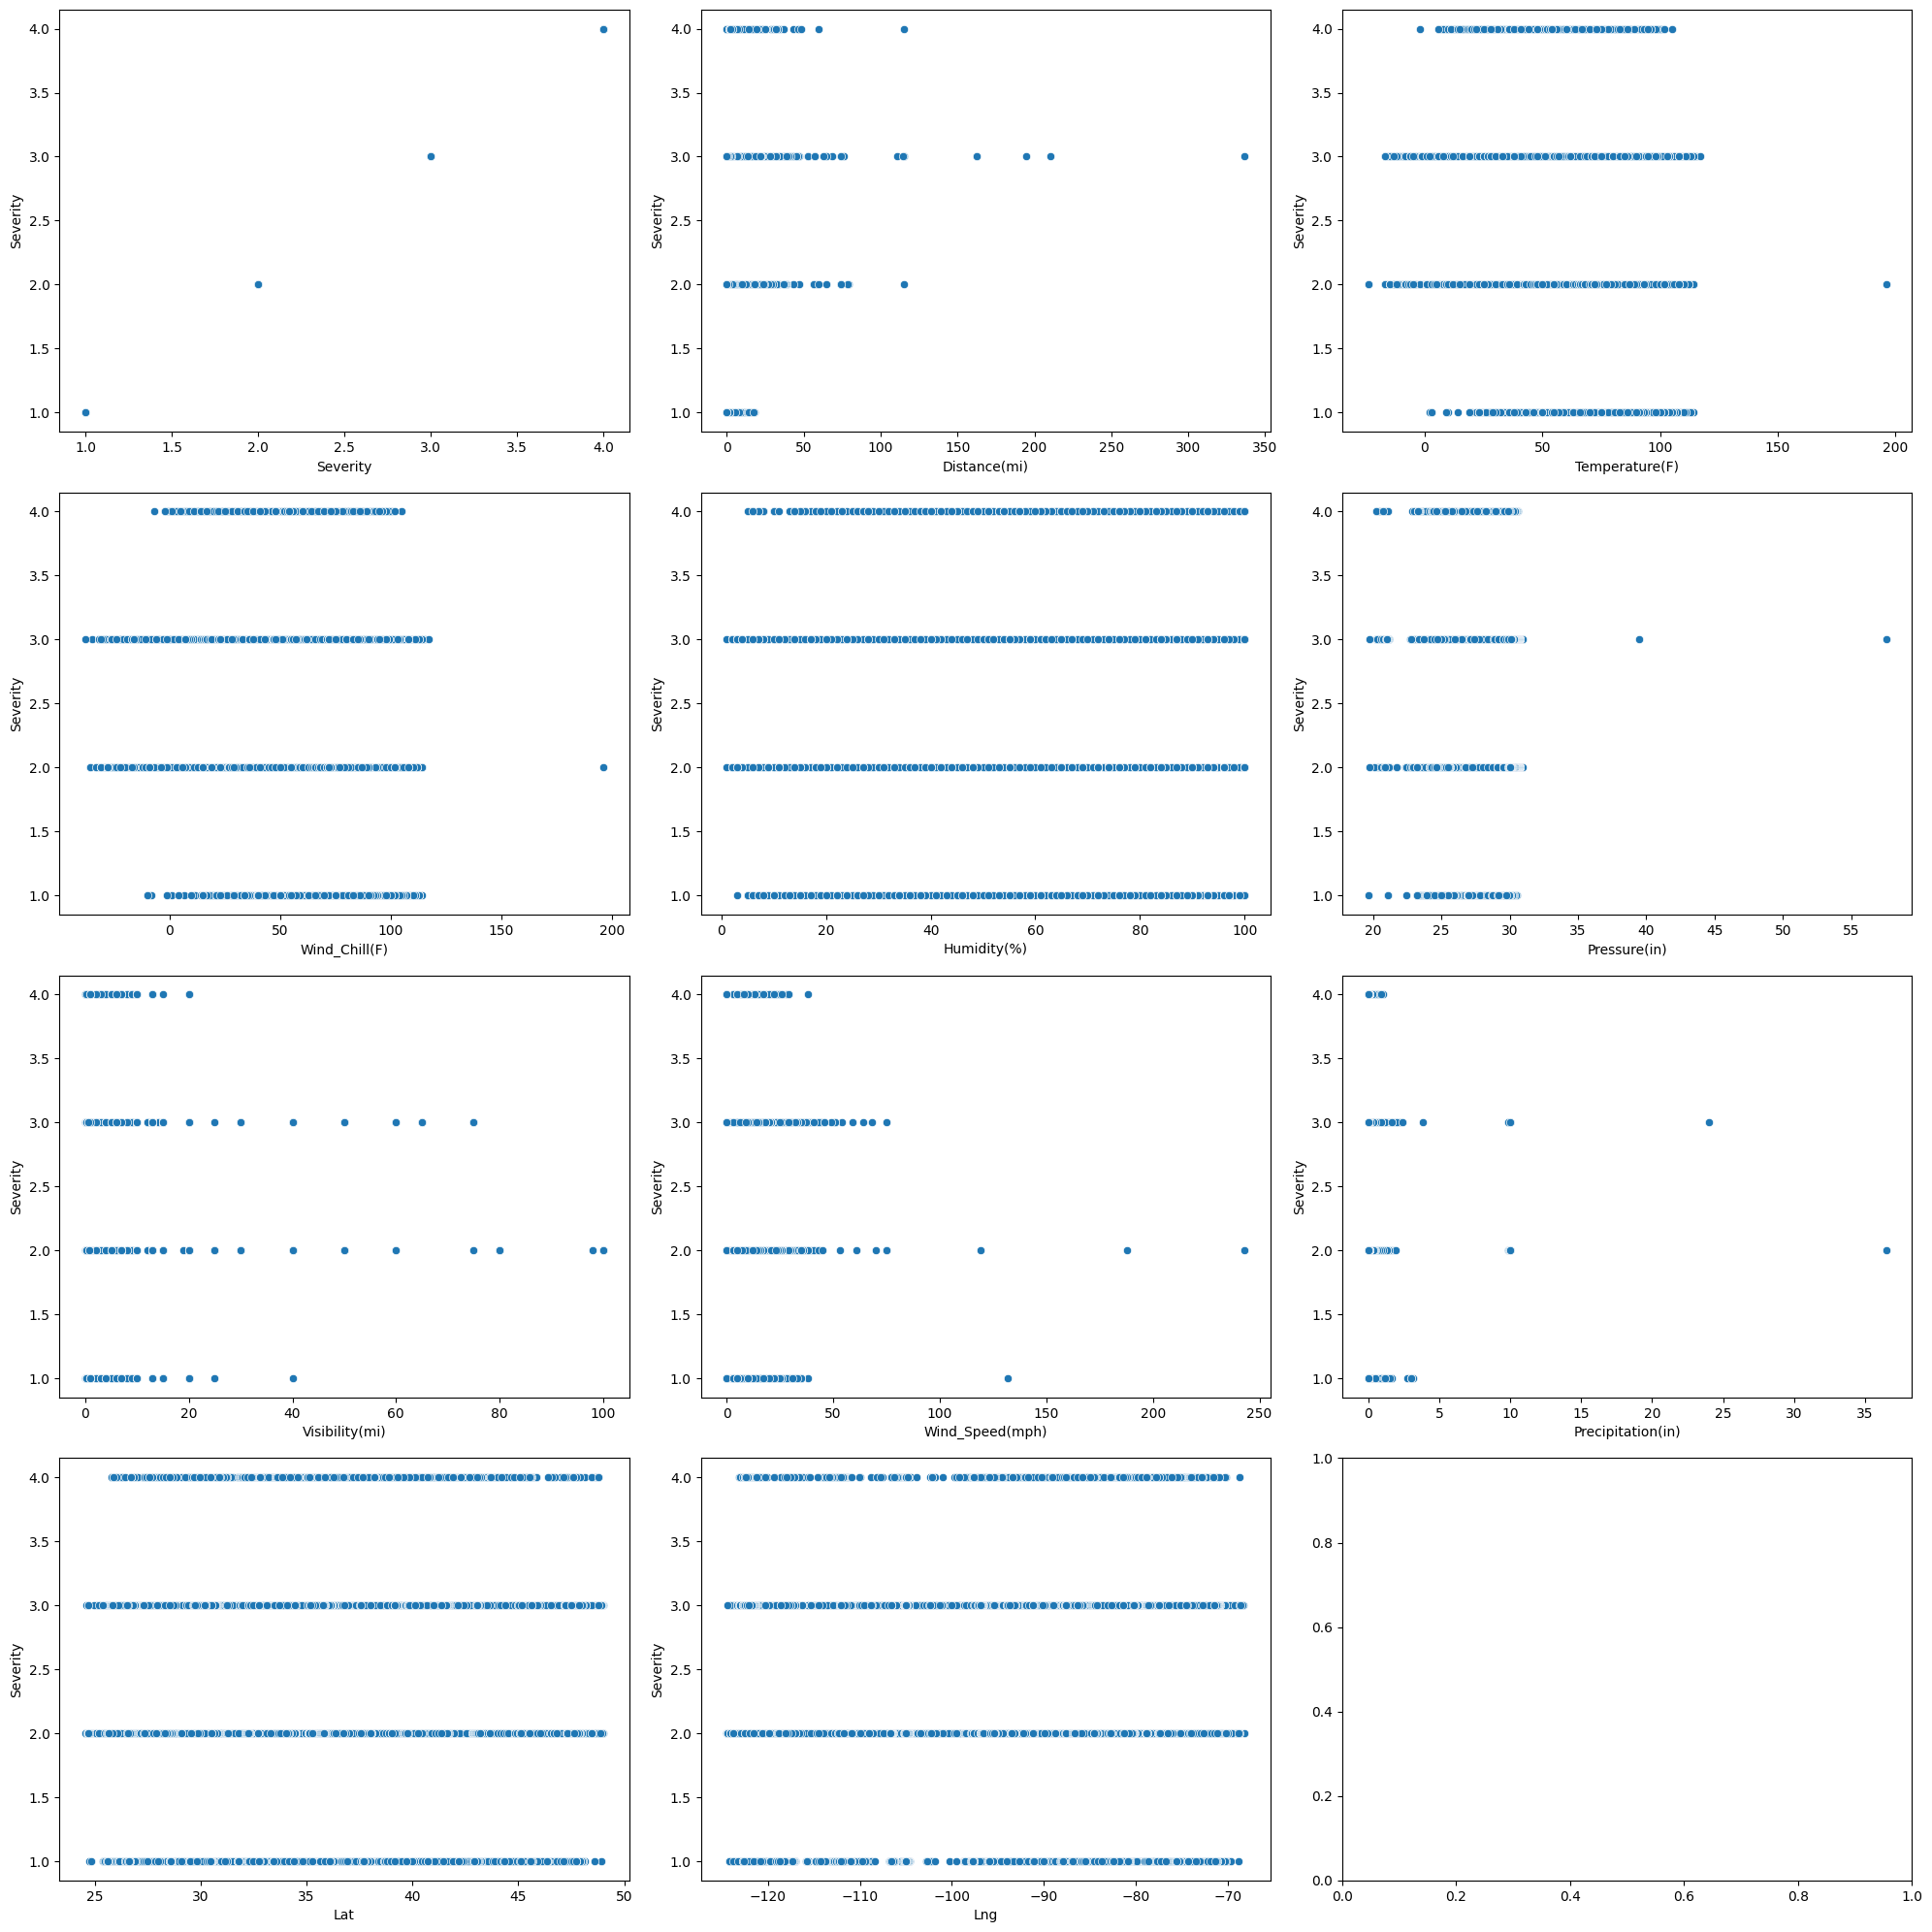

In [23]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
axes_flattened = axes.reshape(-1)

for i in range(len(num_df.columns)):
    ax = axes_flattened[i]
    sns.scatterplot(
        x=num_df.iloc[:, i],
        y='Severity',
        data=num_df.dropna(),
        ax=ax,
    )
fig.tight_layout(pad=1.0)

In [24]:
num_df.describe()

,Severity,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Lat,Lng
count,800000.000000,800000.000000,787794.000000,431568.000000,786776.000000,790135.000000,784864.000000,719780.000000,419905.000000,800000.000000,800000.000000
mean,2.319766,0.167198,64.614401,59.438175,66.046366,29.693673,9.173545,7.769542,0.013153,36.062100,-94.753874
std,0.548387,1.448136,17.444322,21.916278,21.879453,0.790738,2.262463,5.413651,0.202552,4.907113,17.394433
min,1.000000,0.000000,-77.800000,-50.000000,1.000000,2.990000,0.000000,0.000000,0.000000,24.559731,-124.486275
25%,2.000000,0.000000,54.000000,43.000000,50.000000,29.560000,10.000000,4.600000,0.000000,32.925694,-117.370430
50%,2.000000,0.000000,66.900000,64.000000,68.000000,29.910000,10.000000,7.000000,0.000000,35.260948,-87.957367
75%,3.000000,0.010000,77.000000,76.000000,84.000000,30.050000,10.000000,10.400000,0.000000,40.114189,-80.920403
max,4.000000,336.570007,196.000000,196.000000,100.000000,58.030000,111.000000,822.800000,36.470000,48.998085,-68.160789


In [40]:
def corrplot(df_corr, method="pearson", annot=True, **kwargs):
    df_corr = df_corr.dropna()
    matrix_corr = df_corr.corr(method)
    sns.clustermap(
        df_corr.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )
    return matrix_corr

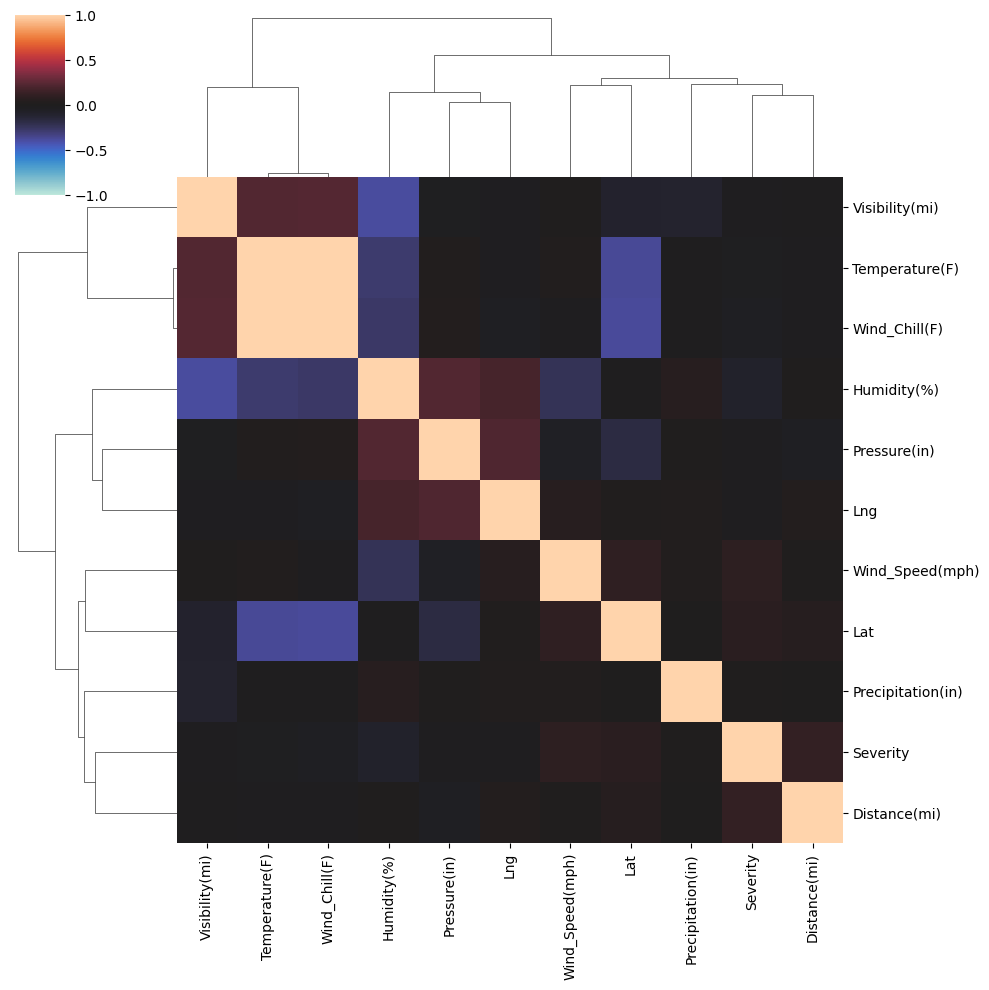

In [26]:
matrix_corr = corrplot(num_df, annot=None)

In [27]:
matrix_corr

,Severity,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Lat,Lng
Severity,1.000000,0.116099,-0.036664,-0.042589,-0.088682,-0.019540,-0.020500,0.086646,0.015474,0.075398,-0.018072
Distance(mi),0.116099,1.000000,-0.021475,-0.023181,0.008610,-0.045377,-0.009448,0.012384,0.001528,0.054660,0.034193
Temperature(F),-0.036664,-0.021475,1.000000,0.994333,-0.284322,0.028596,0.223882,0.027381,-0.011819,-0.373473,-0.026791
Wind_Chill(F),-0.042589,-0.023181,0.994333,1.000000,-0.267010,0.032517,0.227829,-0.022067,-0.012337,-0.380049,-0.040016
Humidity(%),-0.088682,0.008610,-0.284322,-0.267010,1.000000,0.221912,-0.382825,-0.226653,0.061477,-0.011858,0.184457
Pressure(in),-0.019540,-0.045377,0.028596,0.032517,0.221912,1.000000,-0.032648,-0.062132,0.009680,-0.175248,0.211457
Visibility(mi),-0.020500,-0.009448,0.223882,0.227829,-0.382825,-0.032648,1.000000,0.013298,-0.104529,-0.096958,-0.023814
Wind_Speed(mph),0.086646,0.012384,0.027381,-0.022067,-0.226653,-0.062132,0.013298,1.000000,0.024706,0.098486,0.057451
Precipitation(in),0.015474,0.001528,-0.011819,-0.012337,0.061477,0.009680,-0.104529,0.024706,1.000000,0.006051,0.024217
Lat,0.075398,0.054660,-0.373473,-0.380049,-0.011858,-0.175248,-0.096958,0.098486,0.006051,1.000000,0.016024


In [28]:
df.drop(columns=['Wind_Chill(F)'], inplace=True)

In [29]:
nan_df = (df.isnull().mean() * 100).reset_index()
nan_df.columns = ["column_name", "percentage"]
nan_df.sort_values("percentage", ascending=False, inplace=True)

In [30]:
nan_df.head(20)

,column_name,percentage
20,Precipitation(in),47.511875
19,Wind_Speed(mph),10.027500
17,Visibility(mi),1.892000
21,Weather_Condition,1.813375
15,Humidity(%),1.653000
14,Temperature(F),1.525750
18,Wind_Direction,1.349625
16,Pressure(in),1.233125
13,Weather_Timestamp,0.987750
5,Street,0.171750


In [31]:
nan_num_column = ['Wind_Speed(mph)', #mean
                  'Visibility(mi)', #mean
                  'Humidity(%)', #mean
                  'Temperature(F)', #mean
                  'Pressure(in)', #mean
                  'Precipitation(in)' #mean
                  ]

In [32]:
for col_name in nan_num_column:
    df[col_name] = df.groupby('Severity')[col_name].transform(lambda x: x.fillna(x.mean()))

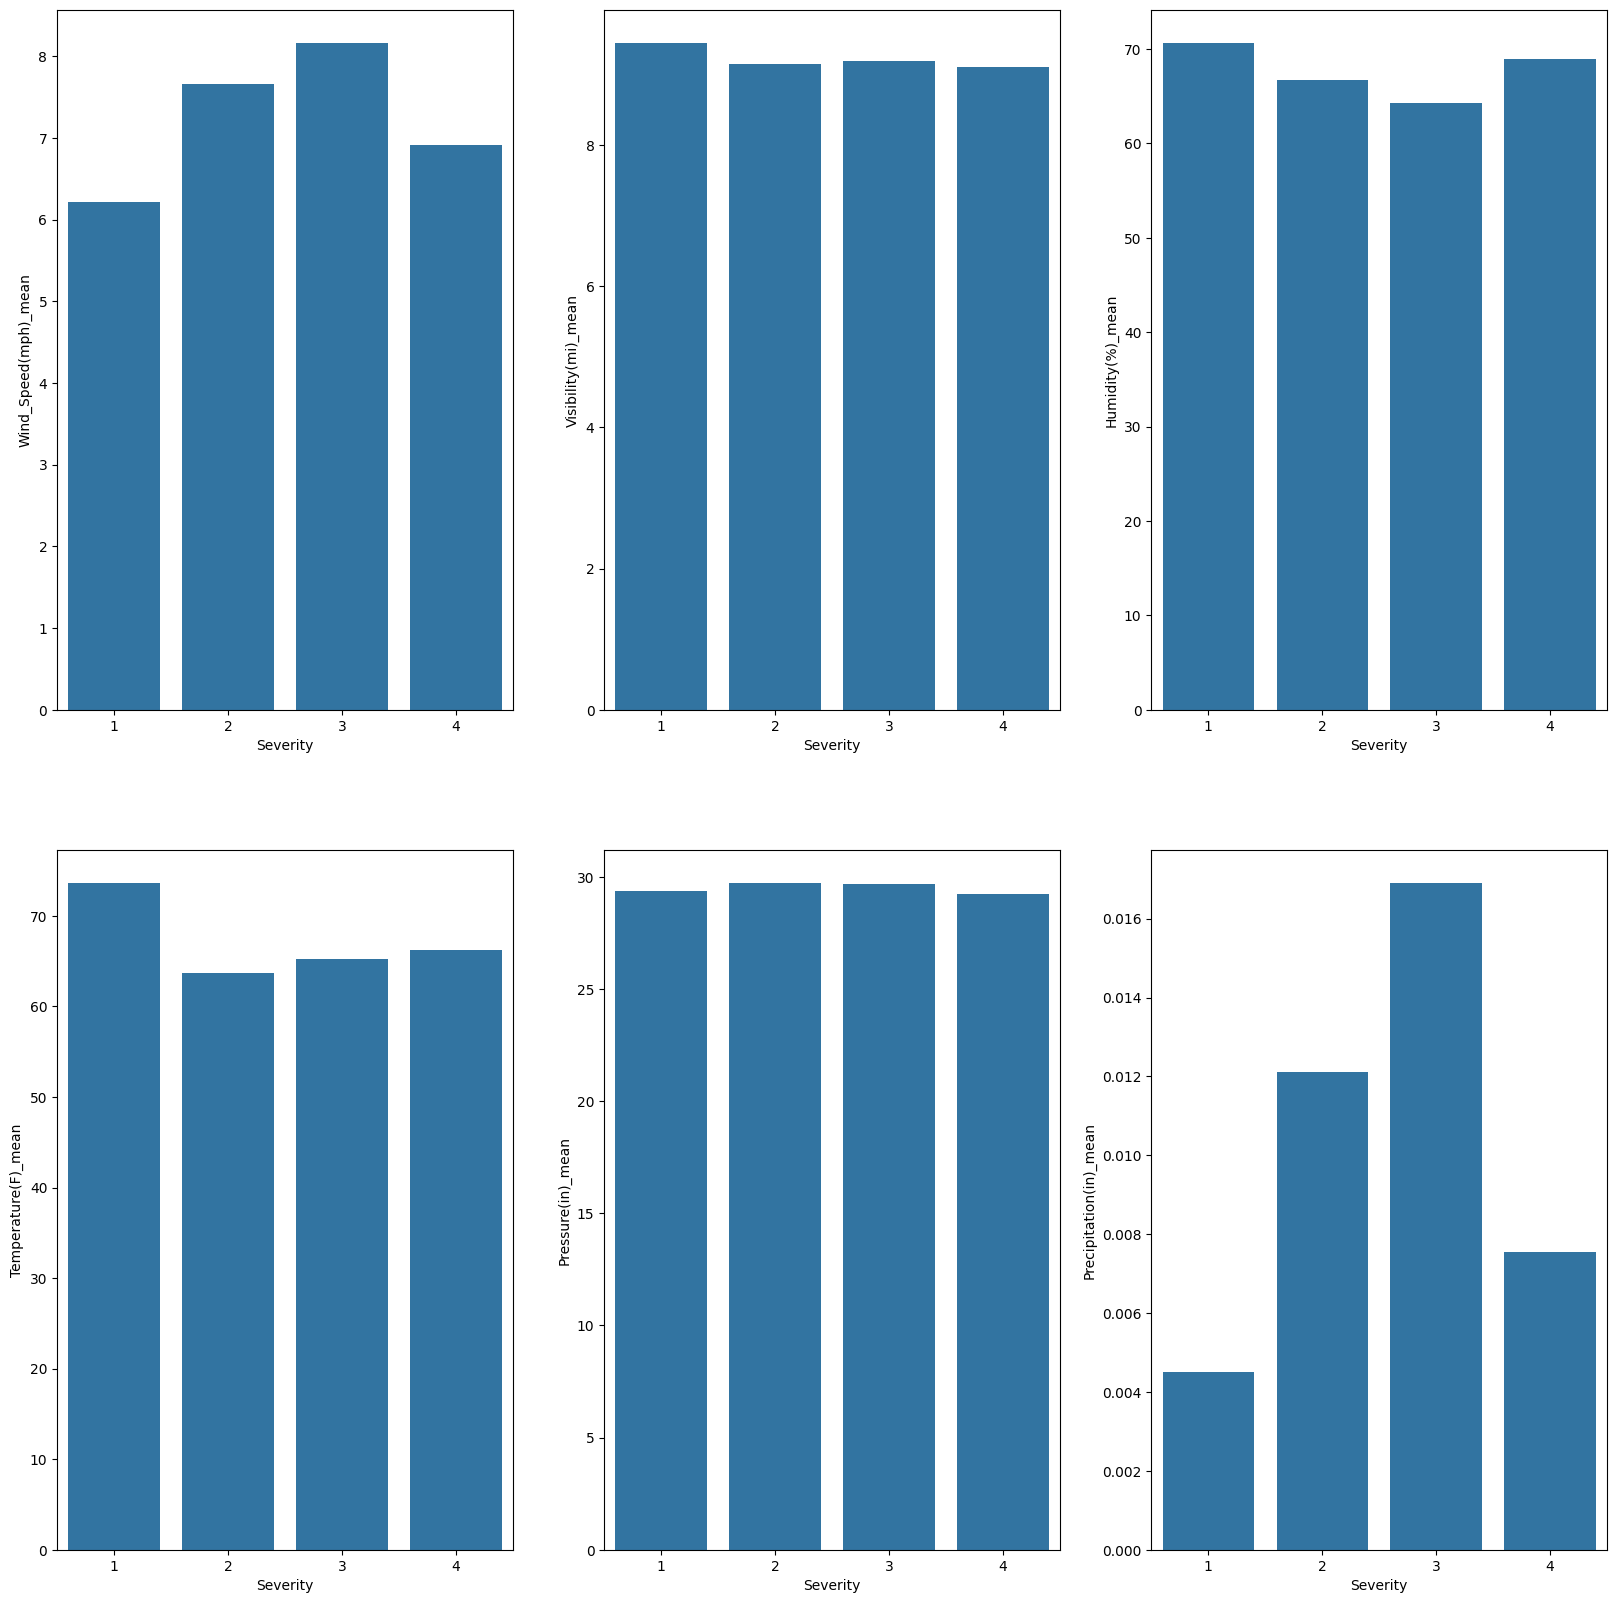

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(20, 20))
axes_flattened = axes.reshape(-1)
Severity_grouped = df.groupby('Severity')
for idx, col_name in enumerate(nan_num_column):
    ax = axes_flattened[idx]
    
    Severity_lot = (
    Severity_grouped[col_name].mean()
    .reset_index(name=f"{col_name}_mean")
    )
    sns.barplot(x='Severity',
                y=f"{col_name}_mean",
                data=Severity_lot, ax=ax)
    
plt.show()

# Удаление столбцов с почти одними и теми же значениями

In [34]:
def get_almost_constant_columns(df: pd.DataFrame, dropna=True, limit: int = 96):
    cols = []
    for i in df:
        if dropna:
            counts = df[i].dropna().value_counts()
        else:
            counts = df[i].value_counts()
        most_popular_value_count = counts.iloc[0]
        if (most_popular_value_count / len(df)) * 100 - limit > 0:
            cols.append(i)
    return cols


In [35]:
overfit_cat = get_almost_constant_columns(cat_df, limit=96)
overfit_cat

['Country']

In [36]:
df.drop(columns=["Country"], inplace=True)

In [37]:
overfit_num = get_almost_constant_columns(num_df, dropna=True, limit=96)
overfit_num

[]

In [38]:
overfit_bool = get_almost_constant_columns(bool_df, dropna=True, limit=99)
overfit_bool

['Bump',
 'Give_Way',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Traffic_Calming',
 'Turning_Loop']

In [39]:
df.columns

Index(['Severity', 'Start_Time', 'End_Time', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Lat', 'Lng'],
      dtype='object')

# Удаление выбросов

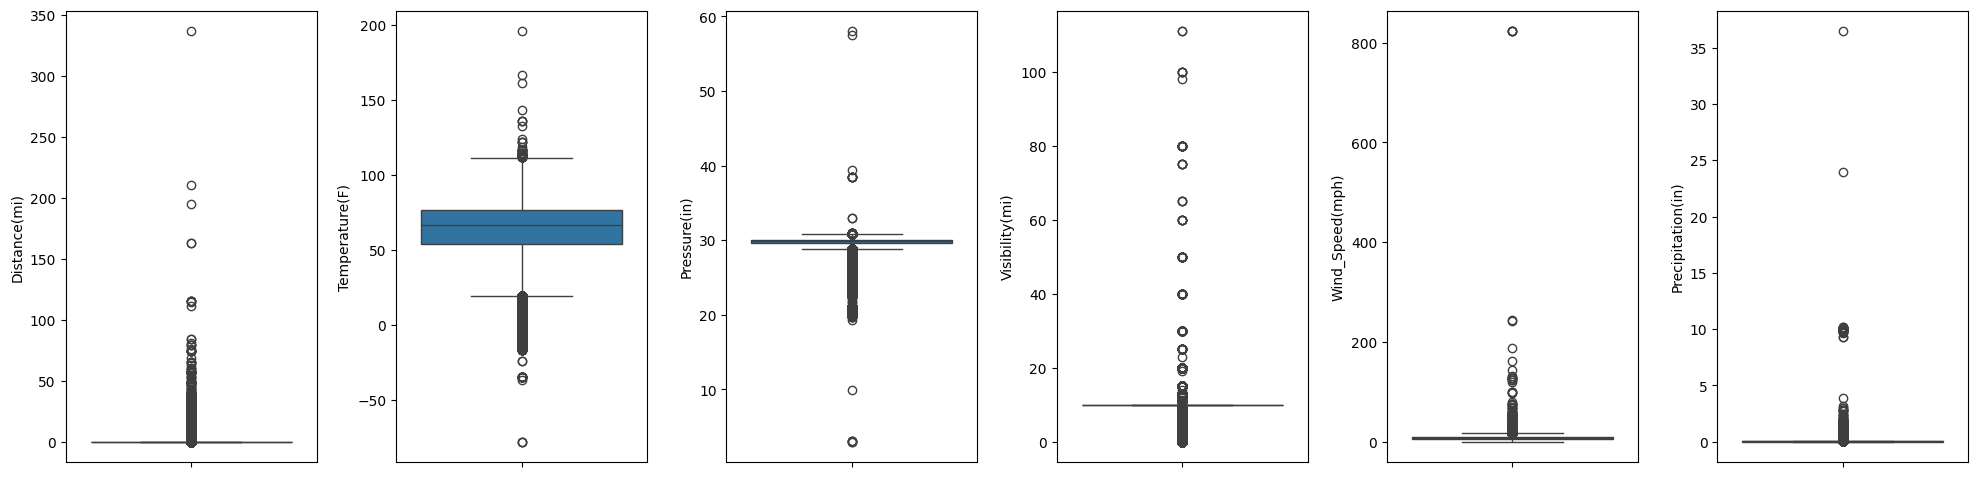

In [40]:
out_col = ["Distance(mi)", "Temperature(F)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"]

fig, axes = plt.subplots(1, 6, figsize=(20, 5))
for ax, col in zip(axes, out_col):
    sns.boxplot(y=df[col], data=df, ax=ax)
fig.tight_layout(pad=1.5)

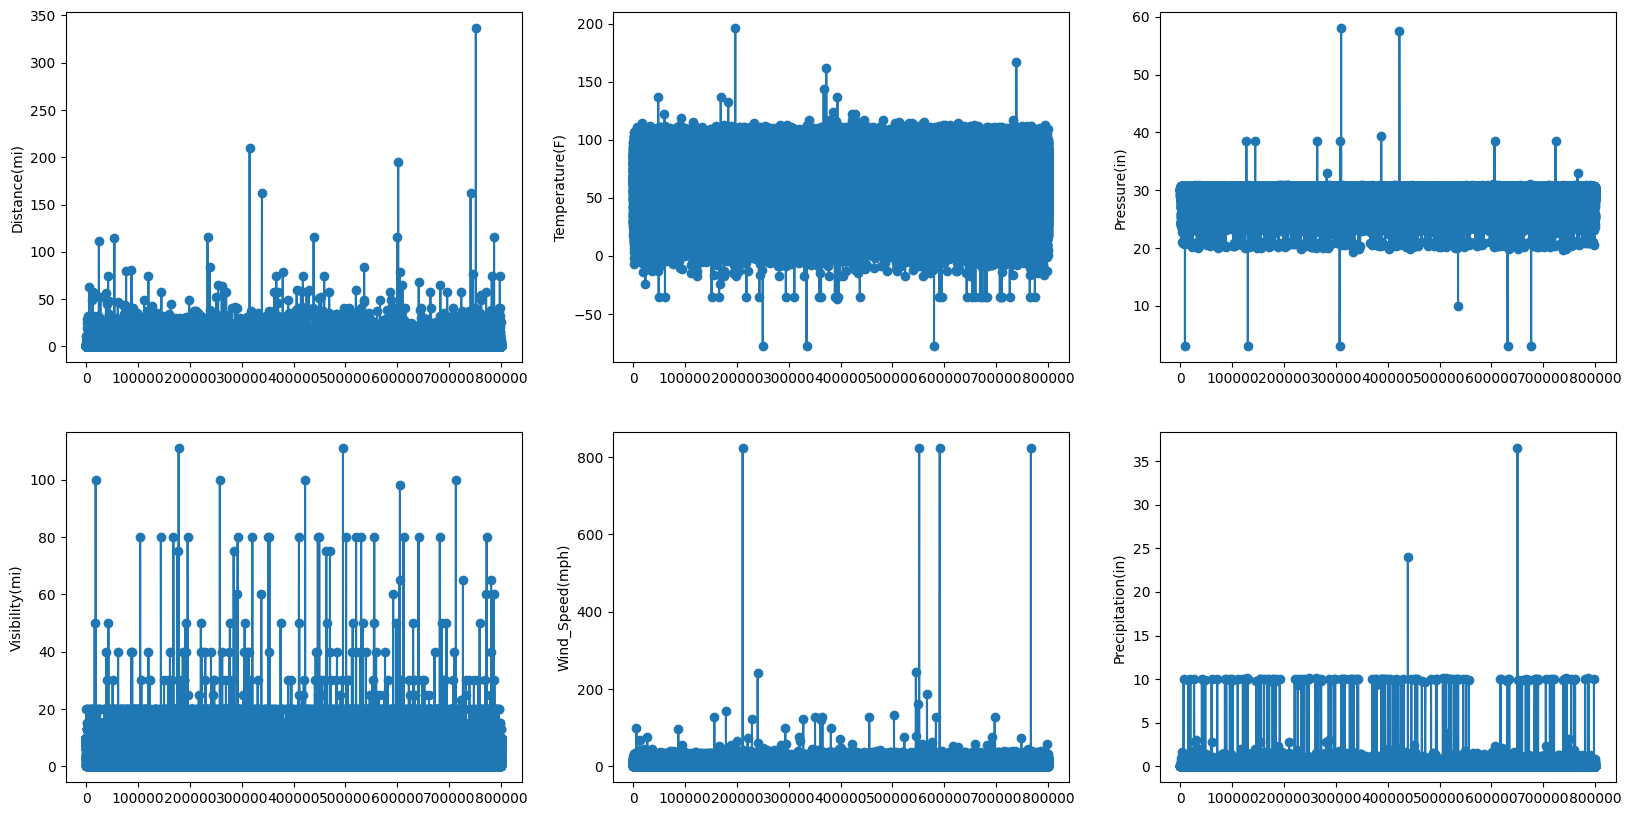

In [41]:
out_col = ["Distance(mi)", "Temperature(F)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"]
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes_flattened = axes.flatten()

for index, column in enumerate(out_col):
    axes[index // 3][index % 3].plot(
        [i + 1 for i in range(len(df[column]))],
        df[column],
        marker='o'
    )
    axes[index // 3][index % 3].set_ylabel(column)

In [42]:
for col, upper_bound, down_bound in (
    ('Distance(mi)', 150, -150),
    ('Temperature(F)', 150, -50),
    ('Pressure(in)', 50, 10),
    ('Visibility(mi)', 100, -100),
    ('Wind_Speed(mph)', 400, -400),
    ("Precipitation(in)",10, -15),
):
    df = df.drop(df[df[col] > upper_bound].index)
    df = df.drop(df[df[col] < down_bound].index)

# Работа с категориальными признаками

In [43]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='mixed').dt.round("S")
df['End_Time'] = pd.to_datetime(df['End_Time'], format='mixed').dt.round("S")
df['Weather_Timestamp'] = pd.to_datetime(df['Weather_Timestamp'], format='mixed').dt.round("S")

<BarContainer object of 2 artists>

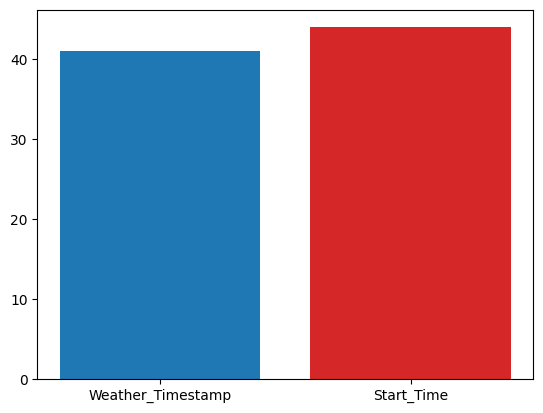

In [44]:
delta_Weather_Timestamp = round((df['End_Time'] - df['Weather_Timestamp']).dt.total_seconds() / 60)
delta_Start_Time = round((df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60)
plt.bar(['Weather_Timestamp', 'Start_Time'], [delta_Weather_Timestamp.median(), delta_Start_Time.median()], color=['tab:blue', 'tab:red'])

In [45]:
df.loc[df['Weather_Timestamp'].isna(), 'Weather_Timestamp'] = df['Start_Time'].loc[df['Weather_Timestamp'].isna()]

In [46]:
df['Start_Date_Year'] = df['Start_Time'].dt.year
df['Start_Date_Month'] = df['Start_Time'].dt.month
df['Start_Date_Day'] = df['Start_Time'].dt.day
df['Start_Date_Hour'] = df['Start_Time'].dt.hour

df['End_Date_Year'] = df['End_Time'].dt.year
df['End_Date_Month'] = df['End_Time'].dt.month
df['End_Date_Day'] = df['End_Time'].dt.day
df['End_Date_Hour'] = df['End_Time'].dt.hour

df['Weather_Datestamp_Year'] = df['Weather_Timestamp'].dt.year
df['Weather_Datestamp_Month'] = df['Weather_Timestamp'].dt.month
df['Weather_Datestamp_Day'] = df['Weather_Timestamp'].dt.day
df['Weather_Datestamp_Hour'] = df['Weather_Timestamp'].dt.hour

In [47]:
df['Time_Difference'] = round((df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60)

In [48]:
df.drop(columns=['Weather_Timestamp', 'Start_Time', 'End_Time'], inplace=True)

In [49]:
new_Twilight_names = {
    'Sunrise_Sunset': 'Is_Day',
    "Civil_Twilight": "Is_Civil_Day",
    "Nautical_Twilight": "Is_Twilight_Day",
    "Astronomical_Twilight": "Is_Astronomical_Day"
}
for column in new_Twilight_names.keys():
    df[new_Twilight_names[column]] = df[column].map({'Day': 1.0, 'Night': 0.0}).astype(float)
df.drop(columns=list(new_Twilight_names.keys()), inplace=True)

In [111]:
num_df = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
bool_df = df.select_dtypes(exclude=['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'object'])
cat_df = df.select_dtypes(include=['object'])
len(num_df.columns), len(bool_df.columns), len(cat_df.columns)

(82, 0, 0)

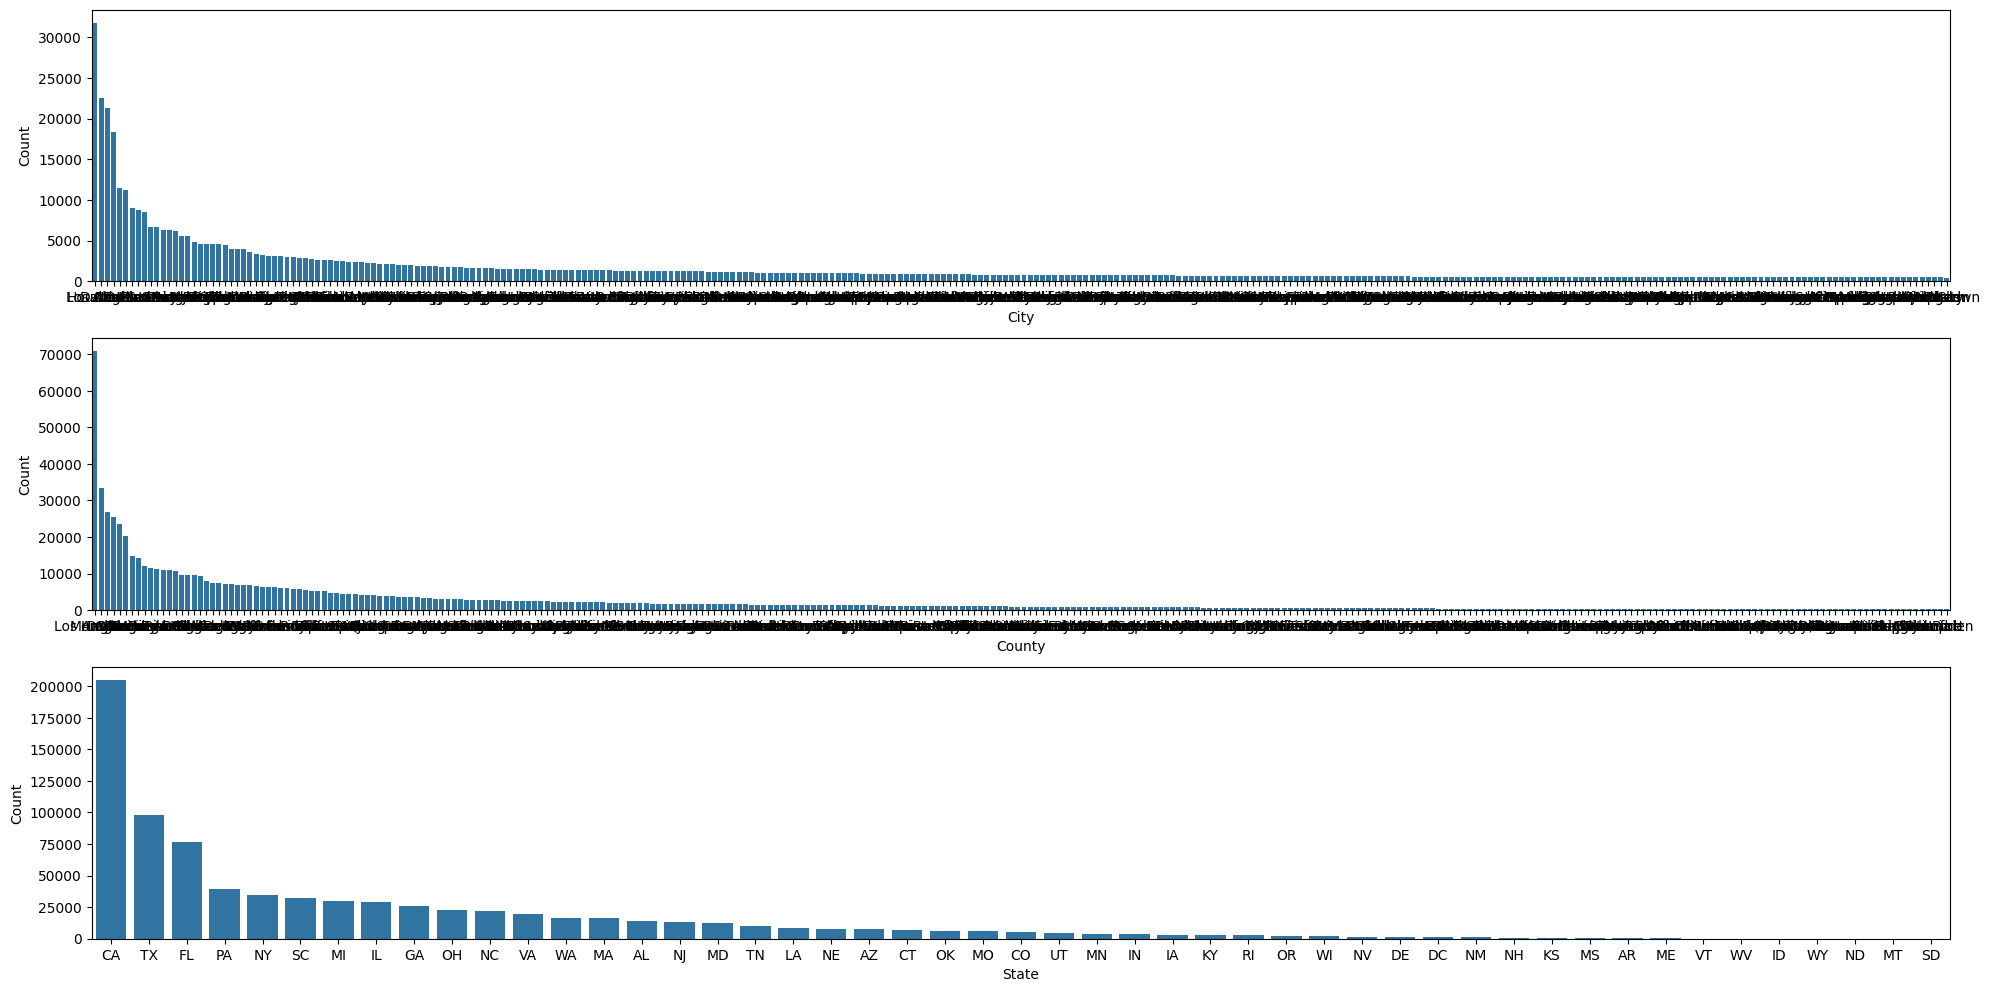

In [86]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10))
axes_flattened = axes.reshape(-1)
count = 300
for idx, column in enumerate(cat_df.columns):
    ax = axes_flattened[idx]
    value_counts = df[column].value_counts()
    viz_df = pd.DataFrame({column: value_counts.index[:count], 'Count': value_counts.values[:count]})
    sns.barplot(
        x=column,
        y='Count',
        data=viz_df.dropna(),
        ax=ax
        )
    
fig.tight_layout(pad=1.0)

In [52]:
df.drop(columns=['Zipcode', 'Airport_Code', 'Description'], inplace=True)

In [53]:
df['Timezone'] = df['Timezone'].replace({
    "US/Eastern": "Easterm",
    "US/Central": "Central",
    "US/Pacific": "Pacific",
    "US/Mountain": "Mountain"
})

In [54]:
nan_df = (df.isnull().mean() * 100).reset_index()
nan_df.columns = ["column_name", "percentage"]
nan_df.sort_values("percentage", ascending=False, inplace=True)
nan_df.head(10)

,column_name,percentage
14,Weather_Condition,1.813102
11,Wind_Direction,1.349701
2,Street,0.171760
46,Is_Astronomical_Day,0.168634
45,Is_Twilight_Day,0.168634
44,Is_Civil_Day,0.168634
43,Is_Day,0.168634
6,Timezone,0.045003
3,City,0.003000
31,Start_Date_Month,0.000000


In [55]:
replacement_words = {
    "Ash": "Ash",
    "Browing": "Browing",
    "Cloud": "Cloudy",
    "Clouds": "Cloudy",
    "Cloudy": "Cloudy",
    "Drizzle": "Rain",
    "Dust": "Dust",
    "Duststorm": "Duststorm",
    "Fair": "Fair",
    "Fog": "Fog",
    "Freezing": "Freezing",
    "Funnel": "Cloudy",
    "Grains": "Hail",
    "Hail": "Hail",
    "Haze": "Fog",
    "Ice": "Ice",
    "Mist": "Fog",
    "Mix": "Mix",
    "Overcast": "Cloudy",
    "Rain": "Rain",
    "Sand": "Dust",
    "Shower": "Rain",
    "Showers": "Rain",
    "Sleet": "Snow",
    "Smoke": "Ash",
    "Snow": "Snow",
    "Squalls": "Squalls",
    "T-Storm": "Tornado",
    "Whirls": "Whirls",
    "Whirlwinds": "Whirls",
    "Windy": "Windy",
    "Wintry": "Snow",
    "Clear": "Clear",
    "Thunder": "Thunder",
    "Thunderstorm": "Thunder",
    "Thunderstorms": "Thunder",
}

In [56]:
df['Weather_Condition'] = df['Weather_Condition'].replace({"N/A": np.nan})

In [57]:
Processed_Weather_Condition = df.dropna()['Weather_Condition'].apply(
    lambda x: ' '.join(
        set(
            sorted(
                    [
                    replacement_words[word] for word in x.split(" ") if word in replacement_words.keys()
                    ]
                )
            )
        ) 
    )
for index in Processed_Weather_Condition.index:
    if 'Mix' in Processed_Weather_Condition[index]:
        Processed_Weather_Condition[index] = 'Mix'
        
df['Weather_Condition'] = Processed_Weather_Condition.replace({'': np.nan})

In [58]:
df['Weather_Condition'] = df.groupby('Severity')['Weather_Condition'].transform(lambda x: x.fillna(x.mode()[0]))

['Rain', 'Clear', 'Fair', 'Cloudy', 'Fog', 'Mix', 'Windy', 'Tornado', 'Thunder', 'Snow', 'Ash', 'Freezing']


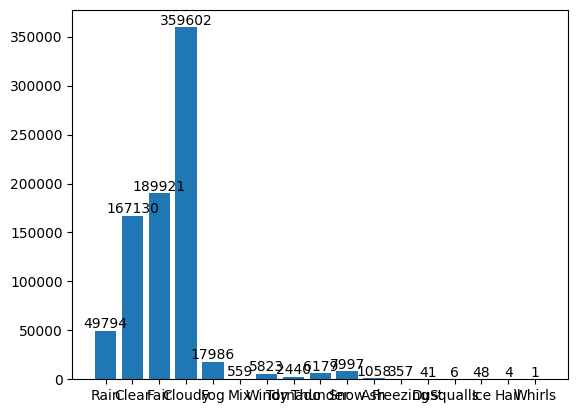

In [59]:
words = set()
repeat_count = dict()
for line in df['Weather_Condition']:
    for word in line.split(" "):
        if word in words:
            repeat_count[word] += 1
        else:
            words.add(word)
            repeat_count[word] = 1    
            
print([word for word in repeat_count.keys() if repeat_count[word] >= 100])

plt.bar(repeat_count.keys(), repeat_count.values())
for idx, count in enumerate(repeat_count.values()):
    plt.text(idx, count, str(count), ha='center', va='bottom')

In [64]:
new_columns = np.zeros((len(words), len(df)), dtype=float)

for i, line in enumerate(df['Weather_Condition']):
    line_words = set(line.split(" "))
    for k, word in enumerate(words):
        if word in line_words:
            new_columns[k][i] = 1.0
            
for idx, word in enumerate(words):
    new_column = pd.Series(new_columns[idx])
    new_column.index = df.index
    df[word] = new_column
    

In [68]:
df.drop(columns=['Weather_Condition'], inplace=True)

In [69]:
df['Wind_Direction'] = df['Wind_Direction'].replace({'South': 'S',
                                                                 'West': 'W',
                                                                 'North': 'N',
                                                                 'Variable': 'VAR',
                                                                 'East': 'E',
                                                                 'Calm': 'CALM'
                                                                 })

In [70]:
df['Wind_Direction'].fillna('VAR', inplace=True)

Почему выкидываем Street:
1) есть Штат, Округ, Координаты. Для нашей задачи этого достаточно
2) На необработанных слишком много классов
3) Слишком проблемно обрабатывать

In [71]:
df.drop(columns=['Street'], inplace=True)

In [72]:
df.dropna(inplace=True)

In [73]:
onehot_encoder = OneHotEncoder(sparse_output=False, min_frequency=5*10**(-4), handle_unknown="ignore")

encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(df[['Timezone', 'Wind_Direction']]))

encoded_categorical_columns.columns = onehot_encoder.get_feature_names_out()
encoded_categorical_columns.index = df.index

encoded_categorical_columns

,Timezone_Central,Timezone_Easterm,Timezone_Mountain,Timezone_Pacific,Wind_Direction_CALM,Wind_Direction_E,Wind_Direction_ENE,Wind_Direction_ESE,Wind_Direction_N,Wind_Direction_NE,...,Wind_Direction_NW,Wind_Direction_S,Wind_Direction_SE,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_VAR,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW
760648,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
771344,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179102,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
75318,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963395,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117952,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
435829,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
305711,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [74]:
for column_name in onehot_encoder.get_feature_names_out():
    df[column_name] = encoded_categorical_columns[column_name]

In [75]:
df.drop(columns=['Timezone', 'Wind_Direction'], inplace=True)

In [103]:
count_encoder_city = ce.CountEncoder(normalize=True)
df['City_Encoded'] = count_encoder_city.fit_transform(df['City'])

count_encoder_county = ce.CountEncoder(normalize=True)
df['County_Encoded'] = count_encoder_city.fit_transform(df['County'])

In [104]:
df.drop(columns=['County', 'City'], inplace=True)

In [108]:
label_encoder_state = LabelEncoder()
encoded = pd.Series(label_encoder_state.fit_transform(df['State']))
encoded.index = df.index
df['State_Encoded'] = encoded

In [109]:
df.drop(columns=['State'], inplace=True)

# Работа с булевыми признаками

In [110]:
for column in bool_df.columns:
    df[column] = df[column].map({True: 1.0, False: 0.0}).astype(float)

# Общий просмотр всех признаков

In [121]:
df.columns

Index(['Severity', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Lat', 'Lng',
       'Start_Date_Year', 'Start_Date_Month', 'Start_Date_Day',
       'Start_Date_Hour', 'End_Date_Year', 'End_Date_Month', 'End_Date_Day',
       'End_Date_Hour', 'Weather_Datestamp_Year', 'Weather_Datestamp_Month',
       'Weather_Datestamp_Day', 'Weather_Datestamp_Hour', 'Time_Difference',
       'Is_Day', 'Is_Civil_Day', 'Is_Twilight_Day', 'Is_Astronomical_Day',
       'Windy', 'Ice', 'Whirls', 'Dust', 'Cloudy', 'Mix', 'Hail', 'Clear',
       'Freezing', 'Fair', 'Ash', 'Squalls', 'Fog', 'Snow', 'Tornado', 'Rain',
       'Thunder', 'Timezone_Central', 'Timezone_Easterm', 'Timezone_Mountain',
       'Timezone_Pacific', 'Wind_Direction_CALM', 

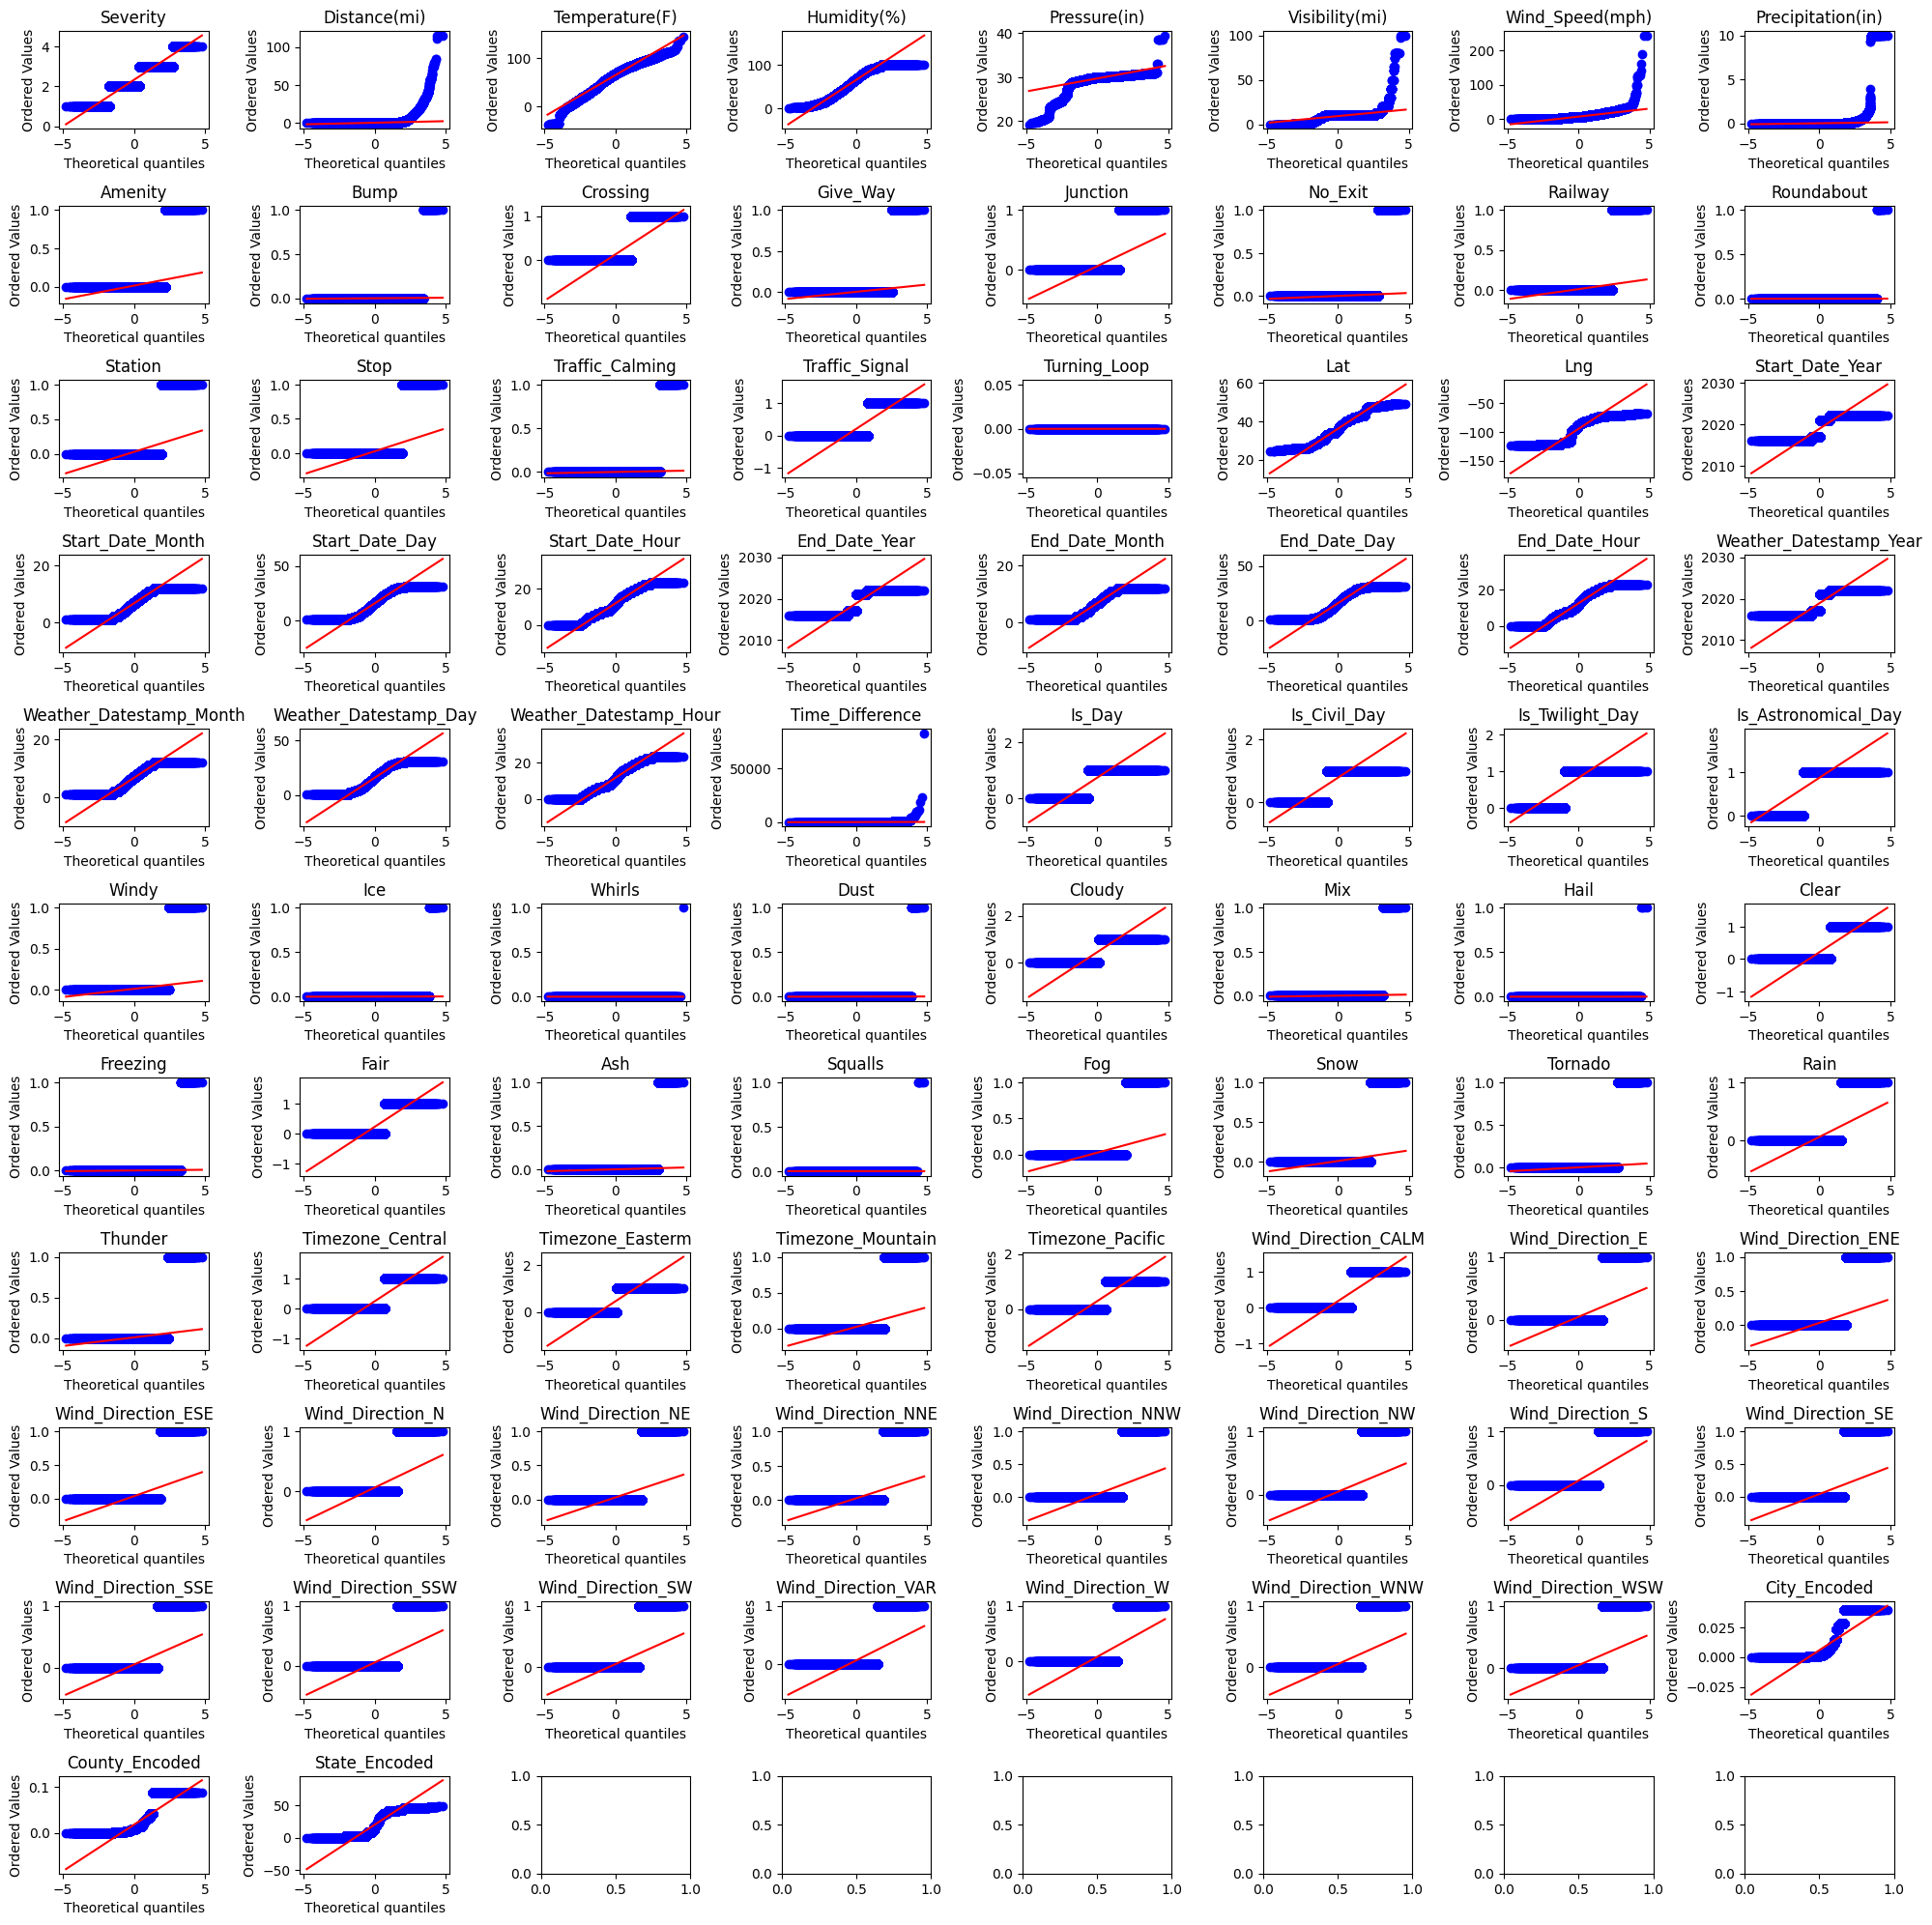

In [128]:
fig, axes = plt.subplots(11, 8, figsize=(20, 20))
axes_flattened = axes.reshape(-1)

for idx, col_name in enumerate(df.columns):
    ax = axes_flattened[idx]
    stats.probplot(df[col_name], dist="norm", plot=ax)
    ax.set_title(col_name)
    
fig.tight_layout(pad=1.0)

# Обучение модели

## Получение и обработка данных

In [7]:
def conversion_boolean_features(df: pd.DataFrame) -> pd.DataFrame:
    bool_df = df.select_dtypes(exclude=['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'object'])
    for column in bool_df.columns:
        df[column] = df[column].map({True: 1.0, False: 0.0}).astype(float)
        
    return df

In [8]:
def add_column_mean_coordinate(start: pd.Series, end: pd.Series) -> pd.Series:
    fill_end = end.fillna(start)
    new_series = (start + fill_end) / 2
    return new_series

def add_mean_coordeenates_parametres(df: pd.DataFrame) -> pd.DataFrame:
    df['Lat'] = add_column_mean_coordinate(df['Start_Lat'], df['End_Lat'])
    df['Lng'] = add_column_mean_coordinate(df['Start_Lng'], df['End_Lng'])
    
    return df

In [9]:
nan_num_column = ['Wind_Speed(mph)', #mean
                  'Visibility(mi)', #mean
                  'Humidity(%)', #mean
                  'Temperature(F)', #mean
                  'Pressure(in)', #mean
                  'Precipitation(in)' #mean
                  ]

def fill_num_columns(df: pd.DataFrame) -> pd.DataFrame:
    for col_name in nan_num_column:
        df[col_name] = df.groupby('Severity')[col_name].transform(lambda x: x.fillna(x.mean()))
        
    return df

In [10]:
def delete_emissions(df: pd.DataFrame) -> pd.DataFrame:
    for col, upper_bound, down_bound in (
        ('Distance(mi)', 150, -150),
        ('Temperature(F)', 150, -50),
        ('Pressure(in)', 50, 10),
        ('Visibility(mi)', 100, -100),
        ('Wind_Speed(mph)', 400, -400),
        ("Precipitation(in)",10, -15),
    ):
        df = df.drop(df[df[col] > upper_bound].index)
        df = df.drop(df[df[col] < down_bound].index)
        
    return df

In [11]:
def process_time_parametres(df: pd.DataFrame) -> pd.DataFrame:
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='mixed').dt.round("S")
    df['End_Time'] = pd.to_datetime(df['End_Time'], format='mixed').dt.round("S")
    df['Weather_Timestamp'] = pd.to_datetime(df['Weather_Timestamp'], format='mixed').dt.round("S")

    df.loc[df['Weather_Timestamp'].isna(), 'Weather_Timestamp'] = df['Start_Time'].loc[df['Weather_Timestamp'].isna()]

    df['Start_Date_Year'] = df['Start_Time'].dt.year
    df['Start_Date_Month'] = df['Start_Time'].dt.month
    df['Start_Date_Day'] = df['Start_Time'].dt.day
    df['Start_Date_Hour'] = df['Start_Time'].dt.hour

    df['End_Date_Year'] = df['End_Time'].dt.year
    df['End_Date_Month'] = df['End_Time'].dt.month
    df['End_Date_Day'] = df['End_Time'].dt.day
    df['End_Date_Hour'] = df['End_Time'].dt.hour

    df['Weather_Datestamp_Year'] = df['Weather_Timestamp'].dt.year
    df['Weather_Datestamp_Month'] = df['Weather_Timestamp'].dt.month
    df['Weather_Datestamp_Day'] = df['Weather_Timestamp'].dt.day
    df['Weather_Datestamp_Hour'] = df['Weather_Timestamp'].dt.hour
    
    return df

In [12]:
new_Twilight_names = {
    'Sunrise_Sunset': 'Is_Day',
    "Civil_Twilight": "Is_Civil_Day",
    "Nautical_Twilight": "Is_Twilight_Day",
    "Astronomical_Twilight": "Is_Astronomical_Day"
}
def rename_Twillight_parametres(df: pd.DataFrame) -> pd.DataFrame:
    for column in new_Twilight_names.keys():
        df[new_Twilight_names[column]] = df[column].map({'Day': 1.0, 'Night': 0.0}).astype(float)
    df.drop(columns=list(new_Twilight_names.keys()), inplace=True)
    
    return df

In [13]:
def rename_Timezone_meanings(df: pd.DataFrame) -> pd.DataFrame:
    df['Timezone'] = df['Timezone'].replace({
        "US/Eastern": "Easterm",
        "US/Central": "Central",
        "US/Pacific": "Pacific",
        "US/Mountain": "Mountain"
    })
    
    return df

In [14]:
def rename_Wind_Direction_paramentres(df: pd.DataFrame) -> pd.DataFrame:
    df['Wind_Direction'] = df['Wind_Direction'].replace({'South': 'S',
                                                                     'West': 'W',
                                                                     'North': 'N',
                                                                     'Variable': 'VAR',
                                                                     'East': 'E',
                                                                     'Calm': 'CALM'
                                                                     })

    df['Wind_Direction'].fillna('VAR', inplace=True)
    
    return df

In [15]:
def drop_excess_parametres(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns=['ID',
                           'Source',
                           'Start_Lat',
                           'Start_Lng',
                           'End_Lat',
                           'End_Lng',
                           'Wind_Chill(F)',
                           'Country',
                           'Zipcode',
                           'Airport_Code',
                           'Description',
                           'Street',
                           'Weather_Timestamp',
                           'Start_Time',
                           'End_Time',
                           ])
    
    df = df.dropna()
    
    return df

In [16]:
def rename_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = rename_Twillight_parametres(df)
    df = rename_Timezone_meanings(df)
    df = rename_Wind_Direction_paramentres(df)
    
    return df

In [17]:
def data_condersion(df: pd.DataFrame) -> pd.DataFrame:
    
    df = conversion_boolean_features(df)
    df = add_mean_coordeenates_parametres(df)
    df = fill_num_columns(df)
    df = delete_emissions(df)
    df = process_time_parametres(df)
    df = rename_columns(df)
    
    return df
    

In [19]:
class WeatherEncoder(TransformerMixin):
    def __init__(self) -> None:
        super().__init__()
        self.words_ = None
        self.replacement_words_ = None
        with open(cfg['type_weather']) as file:
            self.replacement_words_ = json.load(file)
            
    def fit(self, X: pd.Series, y: NDArray = None) -> None:
        self.words_ = set()
        Processed_Weather_Condition = X.dropna().apply(
            lambda x: ' '.join(
                set(
                    sorted(
                            [
                            self.replacement_words_[word] for word in x.split(" ") if word in self.replacement_words_.keys()
                            ]
                        )
                    )
                ) 
            )

        for index in Processed_Weather_Condition.index:
            if 'Mix' in Processed_Weather_Condition[index]:
                Processed_Weather_Condition[index] = 'Mix'

        X = Processed_Weather_Condition.replace({'': np.nan})
        X.fillna(X.mode(), inplace=True)

        for line in X:
            for word in line.split(" "):
                if not word in self.words_:
                    self.words_.add(word)
                    
        return self
                    
    def transform(self, X: pd.Series) -> pd.Series:      
        X.fillna(X.mode(), inplace=True)
        new_columns = np.zeros((len(self.words_), len(X)), dtype=float)

        for i, line in enumerate(X):
            line_words = set(line.split(" "))
            for k, word in enumerate(self.words_):
                if word in line_words:
                    new_columns[k][i] = 1.0

        return_columns = dict()
        for idx, word in enumerate(self.words_):
            new_column = pd.Series(new_columns[idx])
            new_column.index = X.index
            return_columns[word] = new_column
            
        return pd.DataFrame(return_columns)

In [20]:
df = pd.read_csv(cfg["dataset"])

KeyboardInterrupt: 

In [157]:
df = data_condersion(df)

In [158]:
onehot_encoder = OneHotEncoder(sparse_output=False, min_frequency=5*10**(-4), handle_unknown="ignore")

encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(df[['Timezone', 'Wind_Direction']]))

encoded_categorical_columns.columns = onehot_encoder.get_feature_names_out()
encoded_categorical_columns.index = df.index

for column_name in onehot_encoder.get_feature_names_out():
    df[column_name] = encoded_categorical_columns[column_name]


C:\Users\kolos\AppData\Local\Temp\ipykernel_4928\1805234599.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[column_name] = encoded_categorical_columns[column_name]
C:\Users\kolos\AppData\Local\Temp\ipykernel_4928\1805234599.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[column_name] = encoded_categorical_columns[column_name]
C:\Users\kolos\AppData\Local\Temp\ipykernel_4928\1805234599.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many tim

In [159]:
count_encoder_city = ce.CountEncoder(normalize=True)
df['City_Encoded'] = count_encoder_city.fit_transform(df['City'])

C:\Users\kolos\AppData\Local\Temp\ipykernel_4928\3522721204.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train['City_Encoded'] = count_encoder_city.fit_transform(df_train['City'])


In [88]:
count_encoder_county = ce.CountEncoder(normalize=True)
df['County_Encoded'] = count_encoder_county.fit_transform(df['County'])

In [161]:
label_encoder_state = LabelEncoder()
encoded = pd.Series(label_encoder_state.fit_transform(df['State']))
encoded.index = df.index
df['State_Encoded'] = encoded

C:\Users\kolos\AppData\Local\Temp\ipykernel_4928\542561455.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train['State_Encoded'] = encoded


In [162]:
df = drop_excess_parametres(df)

In [139]:
df.head(5)

,Severity,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Amenity,Bump,...,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_VAR,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,City_Encoded,County_Encoded,State_Encoded
760648,2,0.00,41.000000,89.000000,29.02,10.000000,0.000000,0.020000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001913,0.003694,38
79333,3,0.00,82.000000,22.000000,30.01,10.000000,3.500000,0.016902,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.026550,0.088560,3
771344,2,0.00,34.000000,70.000000,29.27,10.000000,9.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000526,0.031707,33
179102,2,0.00,35.100000,71.000000,30.15,10.000000,11.500000,0.012119,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000003,0.000390,20
75318,3,0.01,65.189211,64.288095,30.00,9.182385,8.162544,0.140000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008308,0.018384,3


In [125]:
df.describe()

,Severity,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Amenity,Bump,...,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_VAR,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,City_Encoded,County_Encoded,State_Encoded
count,798606.000000,798606.000000,798606.000000,798606.000000,798606.000000,798606.000000,798606.000000,798606.000000,798606.000000,798606.000000,...,798606.000000,798606.000000,798606.000000,798606.000000,798606.000000,798606.000000,798606.000000,798606.000000,798606.000000,798606.000000
mean,2.319801,0.165093,64.617391,66.036411,29.694030,9.173645,7.772602,0.013194,0.013991,0.000316,...,0.049082,0.055460,0.050437,0.062965,0.075765,0.050309,0.047260,0.005778,0.017920,19.961584
std,0.548134,1.329673,17.308018,21.700154,0.781232,2.234565,4.801395,0.130031,0.117452,0.017761,...,0.216039,0.228877,0.218844,0.242900,0.264621,0.218582,0.212194,0.009940,0.024651,15.561956
min,1.000000,0.000000,-37.000000,1.000000,19.310000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000001,0.000000
25%,2.000000,0.000000,54.000000,50.000000,29.570000,10.000000,5.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000319,0.002653,3.000000
50%,2.000000,0.000000,66.900000,68.000000,29.910000,10.000000,7.656112,0.012119,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001144,0.007994,17.000000
75%,3.000000,0.010000,77.000000,84.000000,30.050000,10.000000,10.000000,0.012119,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005789,0.025210,36.000000
max,4.000000,115.379997,143.600000,100.000000,39.450000,100.000000,243.000000,10.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.039718,0.088560,48.000000


,Severity,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Amenity,Bump,...,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_VAR,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,City_Encoded,County_Encoded,State_Encoded
Severity,1.000000,0.099744,-0.014185,-0.065050,0.021852,-0.006222,0.071463,0.021144,-0.069051,-0.002777,...,-0.001293,0.004678,0.003578,0.009406,0.024035,0.018241,0.012145,-0.031436,0.070991,-0.086177
Distance(mi),0.099744,1.000000,-0.032945,0.016563,-0.070510,-0.013980,-0.001232,-0.001820,-0.012284,-0.001099,...,-0.005439,0.001205,0.001583,0.000032,-0.000215,0.001929,-0.000398,-0.053937,-0.058510,0.021752
Temperature(F),-0.014185,-0.032945,1.000000,-0.306098,0.014701,0.193227,0.020716,-0.008639,-0.010636,0.000093,...,0.052951,0.063593,0.052883,0.085217,-0.021134,-0.049290,0.031335,0.171760,0.122255,-0.064010
Humidity(%),-0.065050,0.016563,-0.306098,1.000000,0.104851,-0.387623,-0.206736,0.038694,0.000663,-0.001347,...,0.018662,-0.020133,-0.024504,-0.081862,-0.079731,-0.083307,-0.038957,-0.021061,-0.103777,0.066562
Pressure(in),0.021852,-0.070510,0.014701,0.104851,1.000000,0.015718,0.017035,0.025521,0.022416,-0.006592,...,-0.012914,-0.016641,-0.019932,0.004574,0.001564,0.009429,-0.015115,0.116051,0.128343,-0.039993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wind_Direction_WNW,0.018241,0.001929,-0.049290,-0.083307,0.009429,0.038566,0.105389,-0.002786,-0.000785,0.000749,...,-0.052290,-0.055772,-0.053045,-0.059663,-0.065898,1.000000,-0.051261,-0.054969,-0.032682,-0.037327
Wind_Direction_WSW,0.012145,-0.000398,0.031335,-0.038957,-0.015115,0.026355,0.049662,-0.000303,-0.004122,-0.000634,...,-0.050600,-0.053968,-0.051330,-0.057734,-0.063768,-0.051261,1.000000,-0.033761,0.021042,-0.042357
City_Encoded,-0.031436,-0.053937,0.171760,-0.021061,0.116051,0.030263,0.031862,0.000625,0.032727,0.002650,...,0.078279,-0.015011,-0.029507,0.024656,-0.045758,-0.054969,-0.033761,1.000000,0.391630,0.284688
County_Encoded,0.070991,-0.058510,0.122255,-0.103777,0.128343,0.024641,-0.042744,-0.004443,-0.005635,-0.000692,...,0.001558,0.004933,-0.006277,0.069108,0.021530,-0.032682,0.021042,0.391630,1.000000,-0.214669


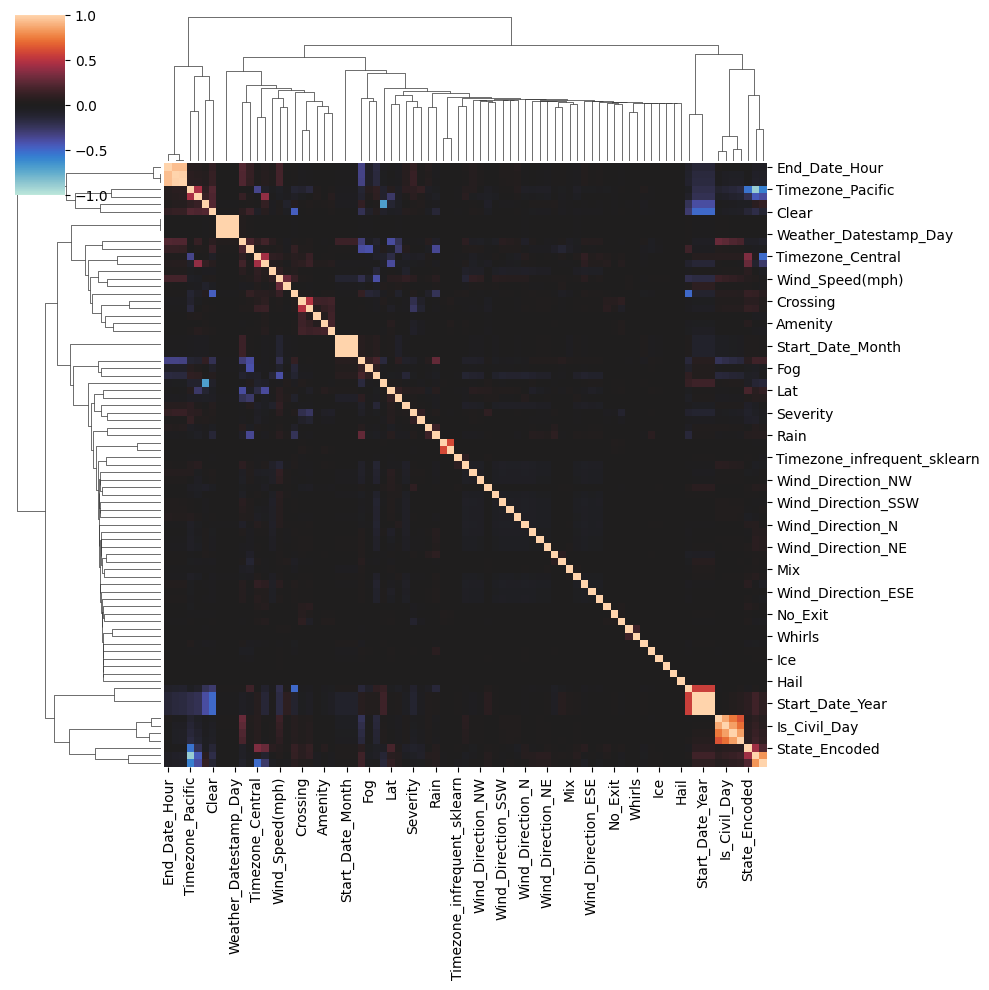

In [75]:
corrplot(df, annot=None)

In [21]:
df = pd.read_csv(cfg["dataset"])[:10**5]
num_colums = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns

In [22]:
df = data_condersion(df)
df = drop_excess_parametres(df)

In [23]:
target_column = 'Severity'
feature_columns = list(df.columns)
feature_columns.remove(target_column)

X = df[feature_columns]
Y = df[target_column]

In [24]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [25]:
count_encoder_city = ce.CountEncoder(normalize=True)
x_train['City_Encoded'] = count_encoder_city.fit_transform(x_train['City'])
x_test['City_Encoded'] = count_encoder_city.transform(x_test['City'])

In [26]:
count_encoder_county = ce.CountEncoder(normalize=True)
x_train['County_Encoded'] = count_encoder_county.fit_transform(x_train['County'])
x_test['County_Encoded'] = count_encoder_county.transform(x_test['County'])

In [27]:
label_encoder_state = LabelEncoder()
encoded = pd.Series(label_encoder_state.fit_transform(x_train['State']))
encoded.index = x_train.index
x_train['State_Encoded'] = encoded
encoded = pd.Series(label_encoder_state.transform(x_test['State']))
encoded.index = x_test.index
x_test['State_Encoded'] = encoded

In [28]:
onehot_encoder = OneHotEncoder(sparse_output=False, min_frequency=5*10**(-4), handle_unknown="ignore")

encoded_categorical_columns_train = pd.DataFrame(onehot_encoder.fit_transform(x_train[['Timezone', 'Wind_Direction']]))
encoded_categorical_columns_test = pd.DataFrame(onehot_encoder.transform(x_test[['Timezone', 'Wind_Direction']]))

encoded_categorical_columns_train.columns = onehot_encoder.get_feature_names_out()
encoded_categorical_columns_train.index = x_train.index

encoded_categorical_columns_test.columns = onehot_encoder.get_feature_names_out()
encoded_categorical_columns_test.index = x_test.index

for column_name in onehot_encoder.get_feature_names_out():
    x_train[column_name] = encoded_categorical_columns_train[column_name]
    x_test[column_name] = encoded_categorical_columns_test[column_name]

In [29]:
weather_transformer = WeatherEncoder()

encoded_train = weather_transformer.fit_transform(x_train['Weather_Condition'])
encoded_test = weather_transformer.transform(x_test['Weather_Condition'])

for word in weather_transformer.words_:
    x_train[word] = encoded_train[word]
    x_test[word] = encoded_test[word]

In [30]:
x_train.drop(columns=['Timezone',
                      'Wind_Direction',
                      'Weather_Condition',
                      'State',
                      'County',
                      'City'
                      ], inplace=True)

x_test.drop(columns=['Timezone',
                      'Wind_Direction',
                      'Weather_Condition',
                      'State',
                      'County',
                      'City'
                      ], inplace=True)

In [31]:
feature_columns = list(x_train.columns)

In [32]:
standard_scaler = StandardScaler()
x_train.loc[:, feature_columns] = standard_scaler.fit_transform(x_train)
x_test.loc[:, feature_columns] = standard_scaler.fit_transform(x_test)

In [33]:
len(x_train), len(y_train), len(x_test), len(y_test)

(78712, 78712, 19678, 19678)

# Модели

### KNN

In [36]:
knn = KNeighborsClassifier(
    n_neighbors=4, metric="cosine", algorithm="brute", weights="uniform"
)

knn.fit(X=x_train, y=y_train)

y_train_pred = knn.predict(X=x_train)
y_test_pred = knn.predict(X=x_test)

print(
    f"train={accuracy_score(y_true=y_train, y_pred=y_train_pred)}"
    "\n"
    f"test={accuracy_score(y_true=y_test, y_pred=y_test_pred)}"
    )
